In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.nips.data_sets.shape_net import pc_loader as sn_pc_loader

from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder


from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence, \
                                     sample_pclouds_distances

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, latent_code_generator_two_layers    

from tf_lab.icml.ae_farm_helper import relevant_class

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
do_plotting = True
ae_loss = 'emd'

save_synthetic_samples = True
save_model = True
saver_step = 10

class_name = raw_input('Give me the class type: ').lower()
ae_id = raw_input('Give me the AE/experiment ID: ').lower()
cmp_type = raw_input('Comparison Type (best epoch vs. max_min epoch): ').lower()

syn_id = shape_net_category_to_synth_id()[class_name]

experiment_name = '_'.join(['nb_gan_ae', ae_id, ae_loss, class_name, str(n_pc_samples), cmp_type, 'epoch'])

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/synthetic_point_clouds'

train_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/gan/nb_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir);

Give me the class type: chair
Give me the AE/experiment ID: 18
Comparison Type (best epoch vs. max_min epoch): best


In [5]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


In [6]:
ae_help = relevant_class(ae_loss)

In [7]:
# Load Auto-Encoder
ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))
reset_tf_graph()
ae = PointNetAutoEncoder(ae_net_name, ae_conf)
bneck = ae.bottleneck_size
assert(ae_help.experiment_id_to_bneck[int(ae_id)] == bneck) 

if cmp_type.startswith('best'):
    load_epoch, _ = ae_help.best_epochs[bneck]
    print load_epoch
elif cmp_type.startswith('max'):
    load_epoch, _ = ae_help.max_min_epochs[bneck]
else:
    assert(False)
    saved_epochs = read_saved_epochs(ae_conf.train_dir)
    load_epoch = saved_epochs[-1]

ae.restore_model(ae_conf.train_dir, load_epoch, verbose=True)

1000
Model restored in epoch 1000.


In [8]:
# Convert raw-data to latent codes.
raw_data = PointCloudDataSet(pclouds, init_shuffle=False)
_, latent_codes, _ = latent_embedding_of_entire_dataset(raw_data, ae, ae_conf)
training_data = PointCloudDataSet(latent_codes)

In [9]:
# TODO : make GAN conf.
init_lr = 0.0001
batch_size = 50

noise_params = {'mu':0, 'sigma': 0.5}
noise_dim = ae.bottleneck_size
max_epochs = 500
beta = 0.9

n_syn_samples = training_data.num_examples  # Same number as original GT data.
n_out = [ae.bottleneck_size]

reset_tf_graph()
gan = LatentGAN(experiment_name, init_lr, n_out, noise_dim, latent_code_discriminator_two_layers, latent_code_generator_two_layers)

In [11]:
# ## NEW ALERT
# cmp_in_sphere = True
# voxel_resolution = 28
# pclouds_ = pclouds_centered_and_half_sphere(pclouds)
# _, gt_grid_var = entropy_of_occupancy_grid(pclouds_, voxel_resolution, in_sphere=cmp_in_sphere)

In [16]:
# ## NEW ALERT
# load_gan_model = True
# if load_gan_model:
#     gan.restore_model(train_dir, 500)
#     syn_latent_data = gan.generate(n_syn_samples, noise_params)
#     syn_data = ae.decode(syn_latent_data)

In [17]:
# ## NEW ALERT
# syn_data = pclouds_centered_and_half_sphere(syn_data)
# _, sample_grid_var = entropy_of_occupancy_grid(syn_data, voxel_resolution, in_sphere=cmp_in_sphere)
# jsd_epoch = jensen_shannon_divergence(sample_grid_var, gt_grid_var)
# print jsd_epoch

0.0198079910055


1 (0.83256747855080504, 0.75470425464488844)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


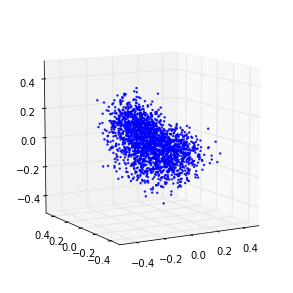

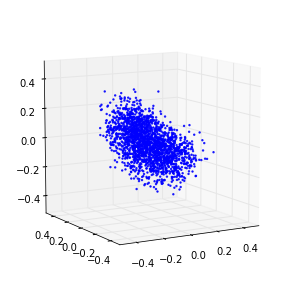

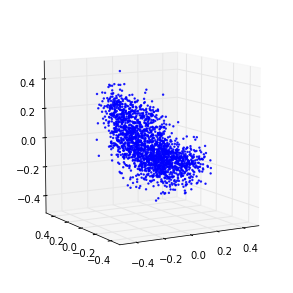

2 (0.39005834736205913, 1.5112234663080286)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


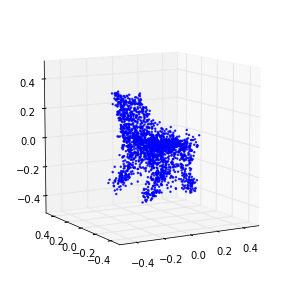

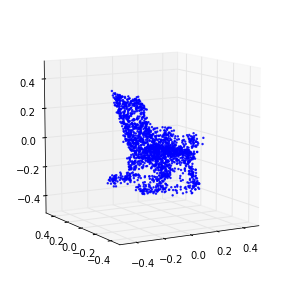

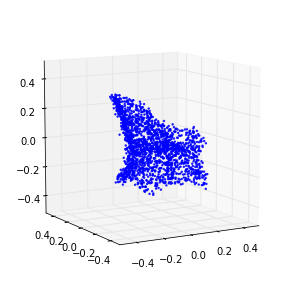

3 (0.43233533678231417, 2.1752329084608291)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


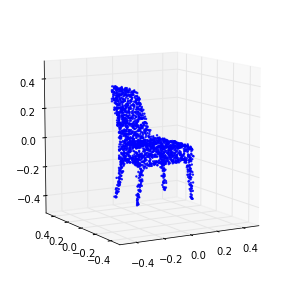

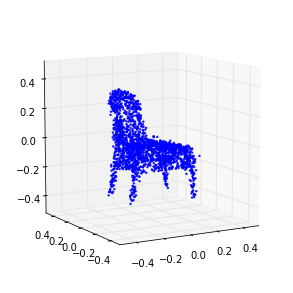

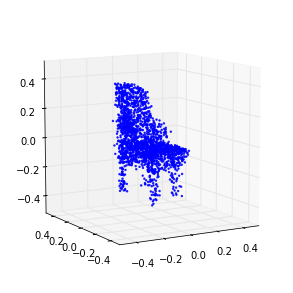

4 (0.91261312409683515, 1.7111385742823282)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


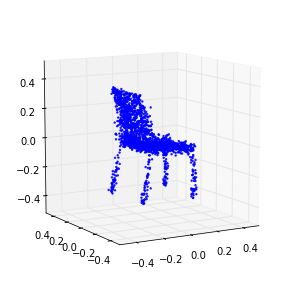

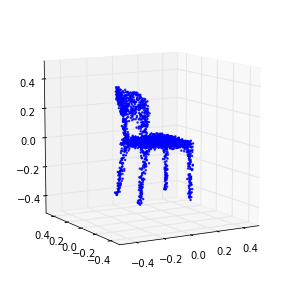

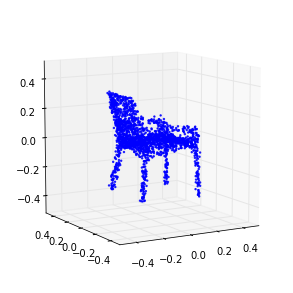

5 (1.2100468542840745, 1.1701756910041528)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


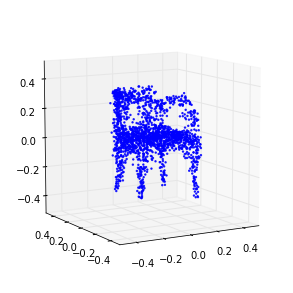

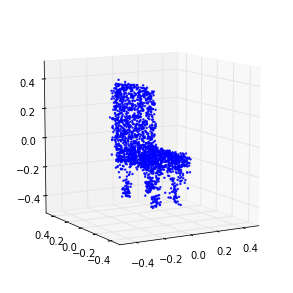

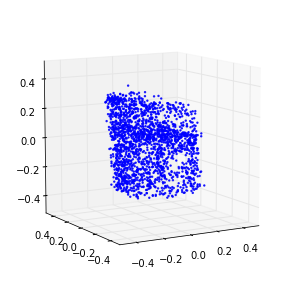

6 (1.2222433001906783, 0.97160543512414999)
7 (1.1908625037581833, 0.90625226188589025)
8 (1.177208669980367, 0.87392389332806619)
9 (1.1821027137615063, 0.87847384126098071)
10 (1.2191887979154235, 0.86256211819472139)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


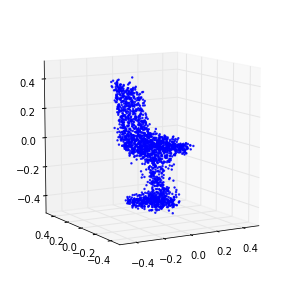

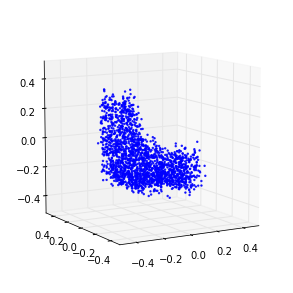

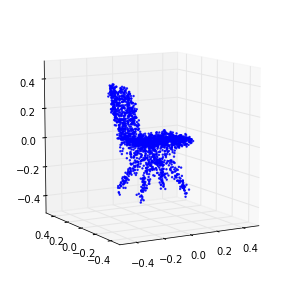

11 (1.2596756387639929, 0.84218405838365906)
12 (1.2888319677776761, 0.81899038111722022)
13 (1.3034933840786969, 0.8055592355904756)
14 (1.3041088342666627, 0.80188632408777871)
15 (1.2859249070838645, 0.81083668514534279)
16 (1.2619048648410374, 0.81685284243689638)
17 (1.2422784964243572, 0.83353518512513902)
18 (1.2466293493906657, 0.83155501816007826)
19 (1.2829036068033288, 0.81421722791813034)
20 (1.3067647624898839, 0.794264805316925)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it.


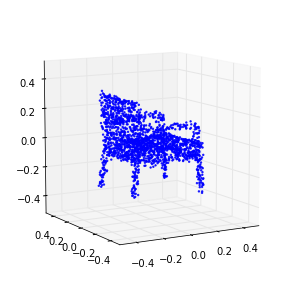

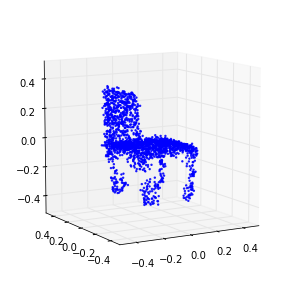

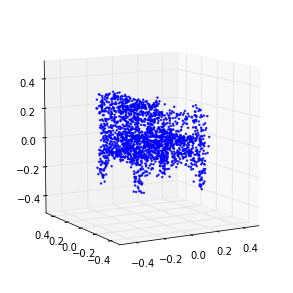

21 (1.3107777312949851, 0.79763192998038401)
22 (1.315401565587079, 0.79035193169558493)
23 (1.318868640617088, 0.78061376191951615)
24 (1.3250698804855348, 0.77304562197791205)
25 (1.3333039010012591, 0.76843780941433382)
26 (1.3296843740675184, 0.75804633608570804)
27 (1.3346445595776593, 0.75800000296698677)
28 (1.336735631801464, 0.75884704987208051)
29 (1.3429668055640327, 0.7492259290483263)
30 (1.345461815374869, 0.73854476125152024)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-30 is not in all_model_checkpoint_paths. Manually adding it.


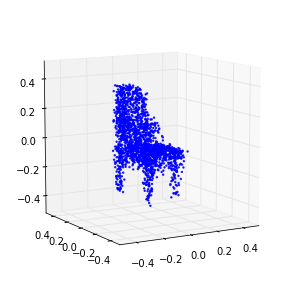

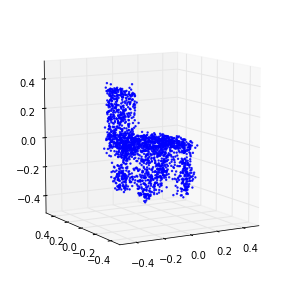

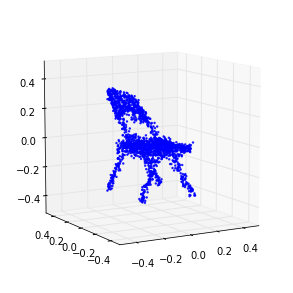

31 (1.3504977296899867, 0.73814348423922505)
32 (1.3481727944480049, 0.74621849192513356)
33 (1.3573002603318955, 0.72551590204238892)
34 (1.3578391357704445, 0.72562983963224625)
35 (1.358770168269122, 0.73497475562272252)
36 (1.3616595594971268, 0.73083131136717616)
37 (1.3643501652611627, 0.72432785652301934)
38 (1.3684382226732041, 0.71882403824064467)
39 (1.372157296427974, 0.71943121309633606)
40 (1.3743358850479126, 0.71961121338385126)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-40 is not in all_model_checkpoint_paths. Manually adding it.


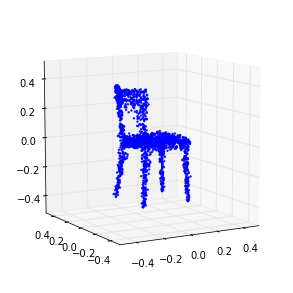

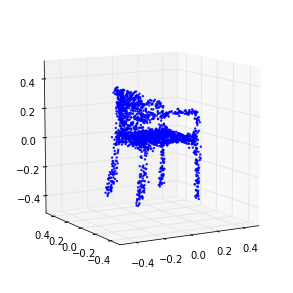

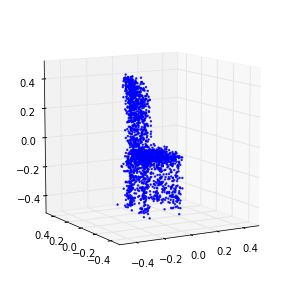

41 (1.3717646369227656, 0.71881990256132899)
42 (1.3750254030580873, 0.71902995065406516)
43 (1.3705752187305027, 0.71940313003681322)
44 (1.3699928319012677, 0.71495855296099631)
45 (1.3707574279220016, 0.71763123008939955)
46 (1.3733736806445651, 0.7222100156324881)
47 (1.3711794447015833, 0.72009357920399419)
48 (1.3730335491674919, 0.71937554368266354)
49 (1.36647000224502, 0.72008785892415927)
50 (1.3831740591261121, 0.72375908516071463)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it.


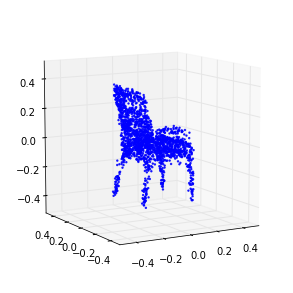

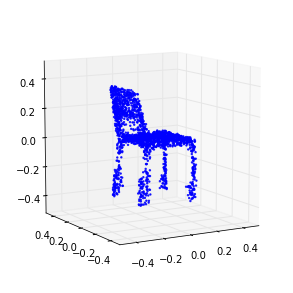

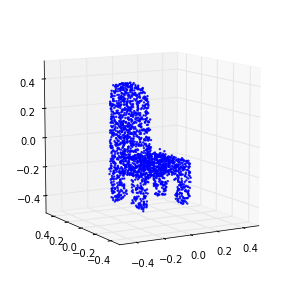

51 (1.3620302995045981, 0.75573526135197389)
52 (1.3758454455269709, 0.70357229577170477)
53 (1.3800599248320968, 0.73290787846953775)
54 (1.366370028036612, 0.73726760104850486)
55 (1.3622330294715033, 0.7079520644964995)
56 (1.3647522723233259, 0.75940348837110727)
57 (1.3687266711835508, 0.69953992366790774)
58 (1.3774030438175908, 0.74168464475207863)
59 (1.3728197971979776, 0.7100853522618612)
60 (1.3733309666315714, 0.71546883936281558)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-60 is not in all_model_checkpoint_paths. Manually adding it.


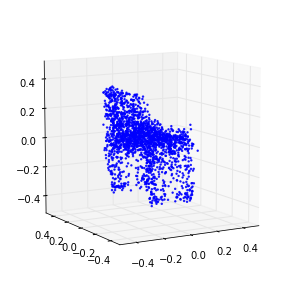

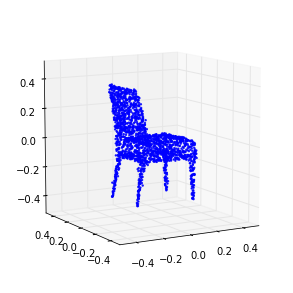

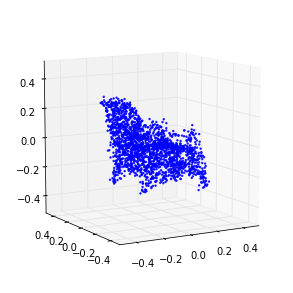

61 (1.3736372276588722, 0.71469000577926634)
62 (1.3715020347524571, 0.70942411687639029)
63 (1.3722703871903597, 0.71834663240997876)
64 (1.3707343684302435, 0.71058042623378614)
65 (1.3722864212813202, 0.71421138048171995)
66 (1.3731081441596702, 0.71339589004163384)
67 (1.3724039660559759, 0.71491557183089083)
68 (1.3719755702548557, 0.71449375373345836)
69 (1.3723905801773071, 0.70748368280905261)
70 (1.373140240598608, 0.70995125858872021)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-70 is not in all_model_checkpoint_paths. Manually adding it.


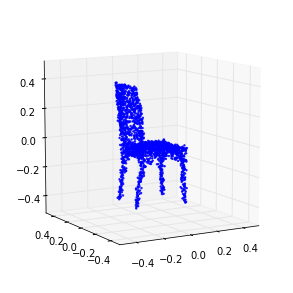

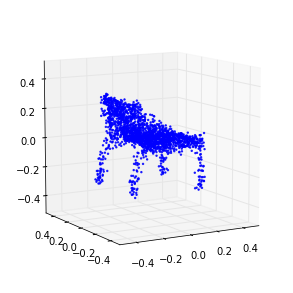

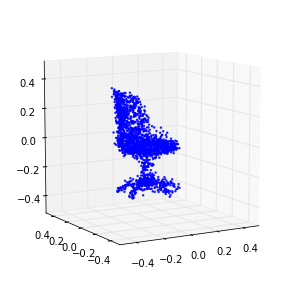

71 (1.3717153469721477, 0.71599735109894369)
72 (1.3735229801248621, 0.71108473715958775)
73 (1.3728859089038989, 0.714744672510359)
74 (1.3723170616008618, 0.71302490940800423)
75 (1.3710983585428309, 0.71329332590103145)
76 (1.3755371597078112, 0.71764747654950178)
77 (1.3668480449252658, 0.72961180651629409)
78 (1.378965934117635, 0.71295808465392496)
79 (1.3694252296730325, 0.70758449898825748)
80 (1.3813410688329626, 0.72310616881759082)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-80 is not in all_model_checkpoint_paths. Manually adding it.


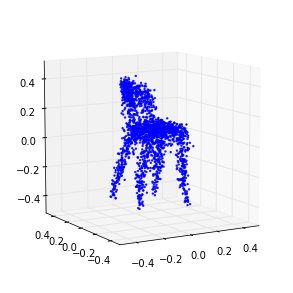

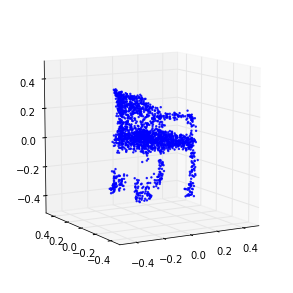

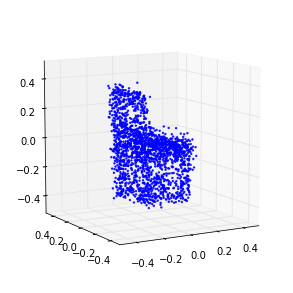

81 (1.3711344683611835, 0.72573053086245498)
82 (1.3762763526704576, 0.70751069563406488)
83 (1.3743468364079794, 0.71096946530871918)
84 (1.3713945371133309, 0.72634787471206097)
85 (1.3792826237501921, 0.70625422663158843)
86 (1.37080355308674, 0.70563340805194996)
87 (1.3763945005558156, 0.72603890366024437)
88 (1.3778652941739118, 0.70972107163182008)
89 (1.3733422252866956, 0.70596480457871047)
90 (1.378829457141735, 0.70925359461042614)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-90 is not in all_model_checkpoint_paths. Manually adding it.


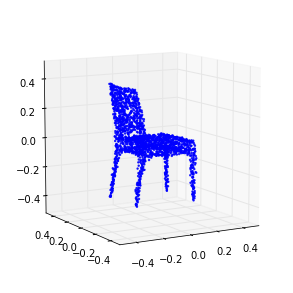

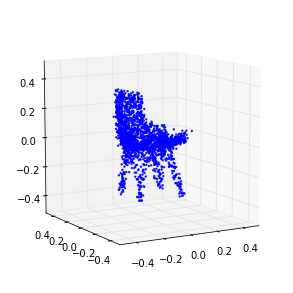

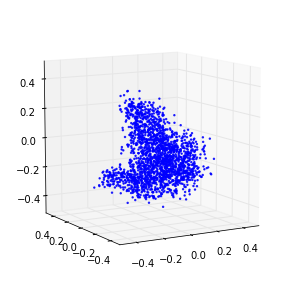

91 (1.3755613017965247, 0.71663997438218863)
92 (1.3771881553861829, 0.70918486913045242)
93 (1.374114563730028, 0.7043228114092791)
94 (1.3777123839766892, 0.71826581469288575)
95 (1.3769525607426962, 0.712706650627984)
96 (1.3775291151470608, 0.70701508654488454)
97 (1.3769142663037335, 0.70353506803512578)
98 (1.3784592849236947, 0.70669917486332079)
99 (1.3743051449457804, 0.71933493084377709)
100 (1.3785585977413035, 0.71353154756404735)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.


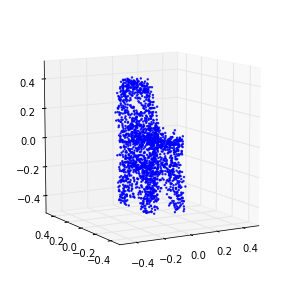

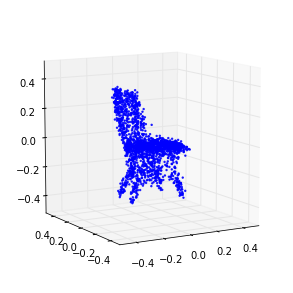

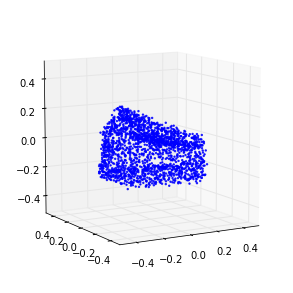

101 (1.3802996238072713, 0.70188593731986149)
102 (1.3778156183384083, 0.70827949532756096)
103 (1.375813411783289, 0.72400909662246704)
104 (1.3776239695372405, 0.70999713297243472)
105 (1.3762100802527533, 0.70220300179940687)
106 (1.3792433950636123, 0.71280811318644766)
107 (1.372354468592891, 0.73291295501920917)
108 (1.381470999011287, 0.70000489464512583)
109 (1.3798629301565666, 0.71115021705627446)
110 (1.3751938766903347, 0.73263613382975257)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-110 is not in all_model_checkpoint_paths. Manually adding it.


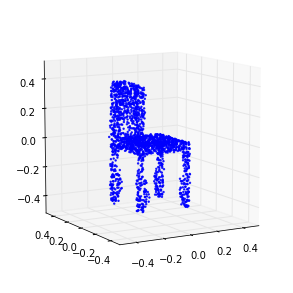

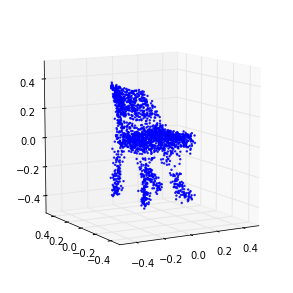

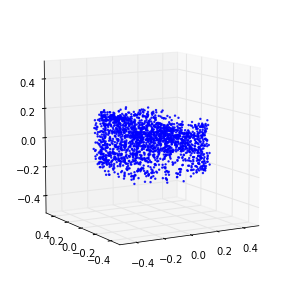

111 (1.3756597059744375, 0.69425627920362687)
112 (1.3842122598930642, 0.72988149854871964)
113 (1.381221385355349, 0.70470227930280893)
114 (1.3788355844992179, 0.70910589871583163)
115 (1.3760650917335793, 0.72284796900219384)
116 (1.3790494565610532, 0.69476092082482799)
117 (1.3796318557527329, 0.71213091656013772)
118 (1.3787230482807866, 0.70115416535624753)
119 (1.3789588539688675, 0.70742882048642197)
120 (1.3769974673235859, 0.71251918209923637)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-120 is not in all_model_checkpoint_paths. Manually adding it.


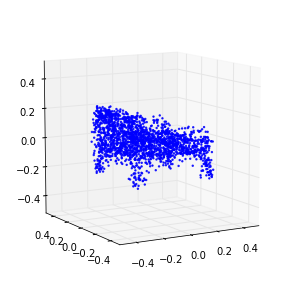

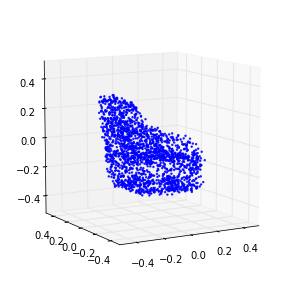

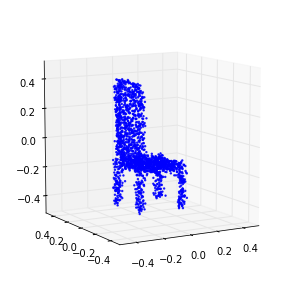

121 (1.3790290982634932, 0.6991570684644911)
122 (1.3787314256032308, 0.70644713110393953)
123 (1.38169499679848, 0.70852500509332728)
124 (1.3782086628454704, 0.70324692681983669)
125 (1.3800170801304006, 0.70438337811717278)
126 (1.3787232045774107, 0.70551598557719475)
127 (1.3801763667000664, 0.7097548100683424)
128 (1.3804827213287354, 0.70877685414420233)
129 (1.3777204646004571, 0.69920837835029315)
130 (1.381693105344419, 0.71122681697209678)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-130 is not in all_model_checkpoint_paths. Manually adding it.


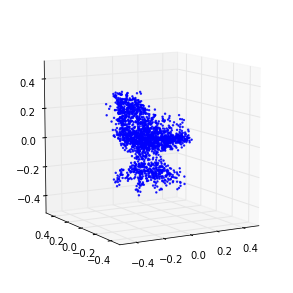

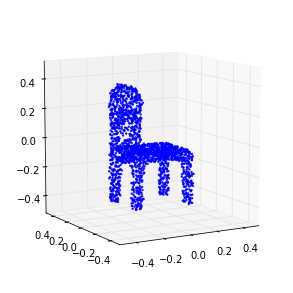

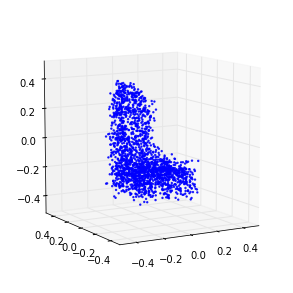

131 (1.3773058908957023, 0.72807615907103929)
132 (1.3847762531704373, 0.70162802051614837)
133 (1.3749047800346657, 0.70247980444519609)
134 (1.3701305618992559, 0.74857433372073701)
135 (1.3820547510076453, 0.68613489115679704)
136 (1.3854589585904722, 0.73830068332177623)
137 (1.3806999418470594, 0.69874180069676151)
138 (1.3786120379412616, 0.72049757595415465)
139 (1.3755792644288805, 0.71490507567370376)
140 (1.3793052479072854, 0.70247926712036135)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-140 is not in all_model_checkpoint_paths. Manually adding it.


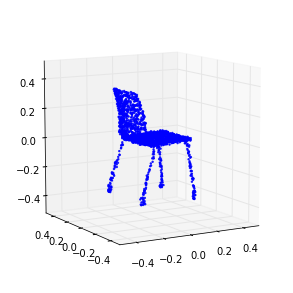

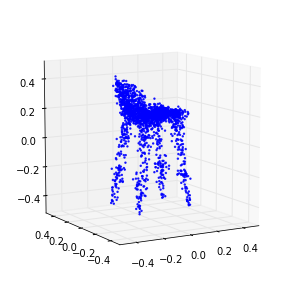

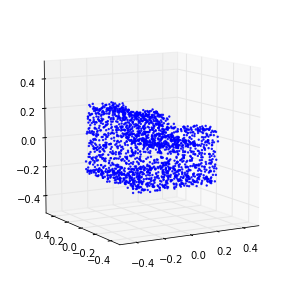

141 (1.3799070393597639, 0.71656836624498721)
142 (1.3808055904176499, 0.6971710593612106)
143 (1.3784899490850944, 0.71666577524609032)
144 (1.3788960642284818, 0.69551364934002913)
145 (1.3802910999015525, 0.71703445778952701)
146 (1.3819338242212931, 0.70426353216171267)
147 (1.3793157083016854, 0.7022410768049735)
148 (1.3767365455627441, 0.71103399991989136)
149 (1.3809598887408221, 0.69611396789550783)
150 (1.3795773179442794, 0.71066097815831497)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-150 is not in all_model_checkpoint_paths. Manually adding it.


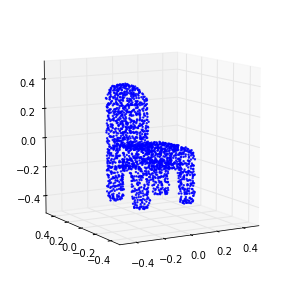

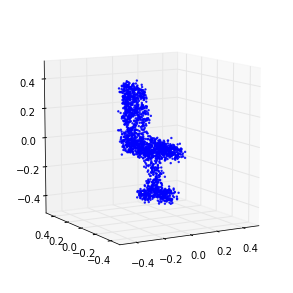

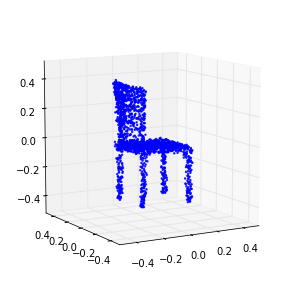

151 (1.378156418270535, 0.70786420239342585)
152 (1.3797160360548231, 0.69531704673060668)
153 (1.3825021505355835, 0.70904836610511501)
154 (1.3778292081974171, 0.71674143208397756)
155 (1.3789252881650571, 0.69444021074860185)
156 (1.3840947115862812, 0.71306315704628276)
157 (1.3795633210076226, 0.72642162773344254)
158 (1.3765805094330399, 0.68851270852265534)
159 (1.3817167423389576, 0.73194251634456498)
160 (1.3840780072742038, 0.68969618965078283)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-160 is not in all_model_checkpoint_paths. Manually adding it.


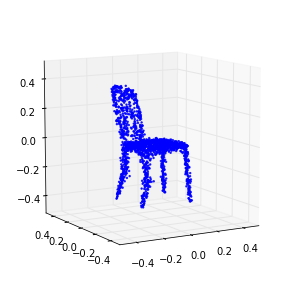

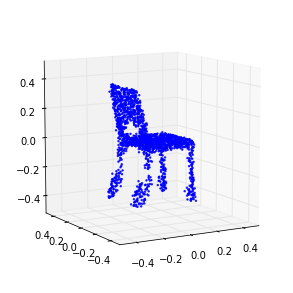

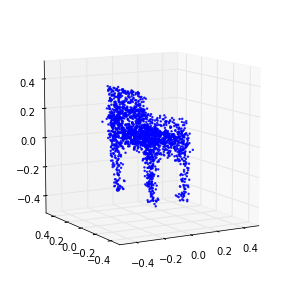

161 (1.3799938608098914, 0.71443543610749416)
162 (1.3811694418942486, 0.70508968565199115)
163 (1.3787826847147058, 0.70356290605333116)
164 (1.3776297286704735, 0.7199122027114585)
165 (1.37987486521403, 0.69321177358980535)
166 (1.3781798742435596, 0.71827073317986945)
167 (1.3798697392145793, 0.6991901790654218)
168 (1.38079903655582, 0.7049990565688522)
169 (1.3792206287384032, 0.70702421974252772)
170 (1.3792975425720215, 0.69565163850784306)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-170 is not in all_model_checkpoint_paths. Manually adding it.


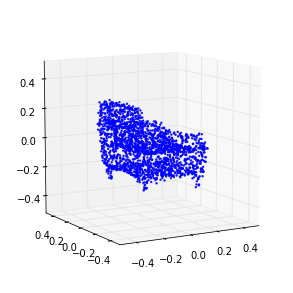

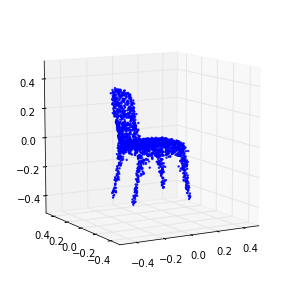

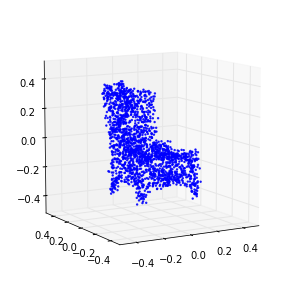

171 (1.3814910570780436, 0.71465498253151227)
172 (1.3804026135691889, 0.7025807892834699)
173 (1.380613911593402, 0.70227967898050947)
174 (1.37913295339655, 0.71337630042323363)
175 (1.3810351636674669, 0.6968280227095992)
176 (1.3805045481081362, 0.70271023026219126)
177 (1.3773566157729538, 0.72222693761189782)
178 (1.3811591095394558, 0.69279789792166813)
179 (1.381430079318859, 0.71217419129830817)
180 (1.3798793130450779, 0.71529447281802139)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-180 is not in all_model_checkpoint_paths. Manually adding it.


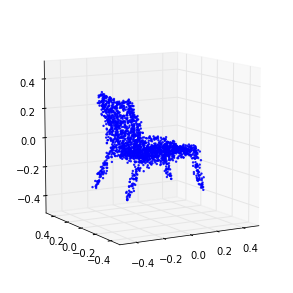

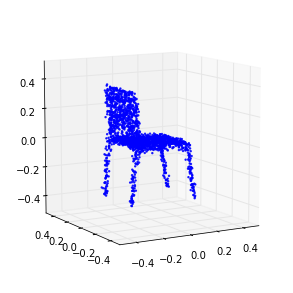

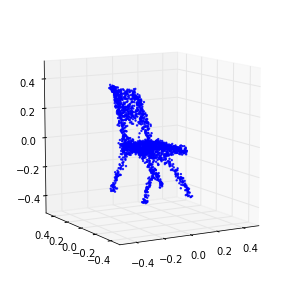

181 (1.3807652155558268, 0.69004148200706195)
182 (1.3792508425535979, 0.72375065485636392)
183 (1.3830500514418991, 0.69373257601702654)
184 (1.3812221597742151, 0.70919703289314551)
185 (1.3784231812865646, 0.71775679235105161)
186 (1.378164008811668, 0.69101208669167979)
187 (1.3785729125693993, 0.73006191606874815)
188 (1.3822409991864806, 0.69284718610622265)
189 (1.3812649223539564, 0.71135101097601428)
190 (1.3795829666985406, 0.70507413193031598)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-190 is not in all_model_checkpoint_paths. Manually adding it.


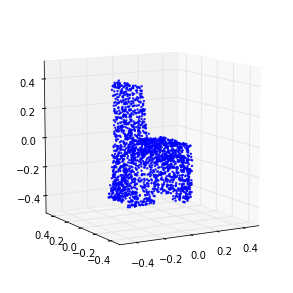

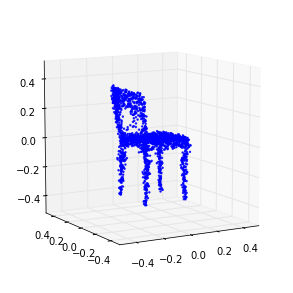

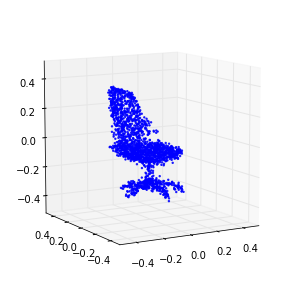

191 (1.3799013526351362, 0.70055389978267524)
192 (1.3785419711360225, 0.71693845943168355)
193 (1.3791263227109556, 0.68989473007343438)
194 (1.380807594899778, 0.71748332624082212)
195 (1.3820784524635032, 0.69429215148643209)
196 (1.3795052122186731, 0.70854814361642904)
197 (1.3805679780465585, 0.70594783138345785)
198 (1.3791302769272415, 0.69468877624582359)
199 (1.3804715571580111, 0.71871259212493899)
200 (1.3844347565262407, 0.69289304547839692)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-200 is not in all_model_checkpoint_paths. Manually adding it.


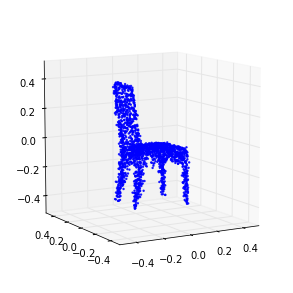

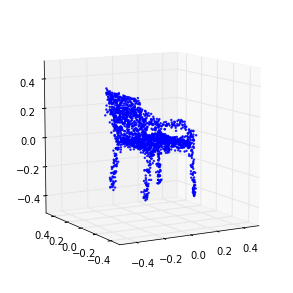

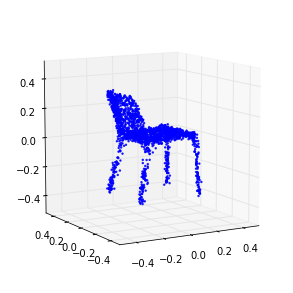

201 (1.3814601050482855, 0.70517665280236141)
202 (1.3778093894322714, 0.71569267025700323)
203 (1.3808971546314381, 0.68954952646184853)
204 (1.3823303134353073, 0.71482224067052202)
205 (1.3801624359907927, 0.70210801539597689)
206 (1.3809876574410334, 0.69982905961849073)
207 (1.3811201634230437, 0.71170535882314045)
208 (1.3810486652232983, 0.69284841042977796)
209 (1.3800300651126438, 0.70830514430999758)
210 (1.3814509082723547, 0.71283759276072189)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-210 is not in all_model_checkpoint_paths. Manually adding it.


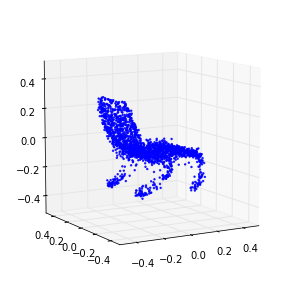

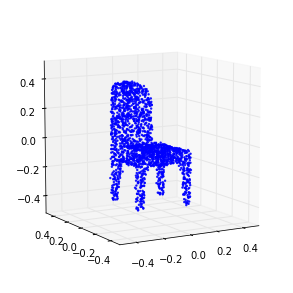

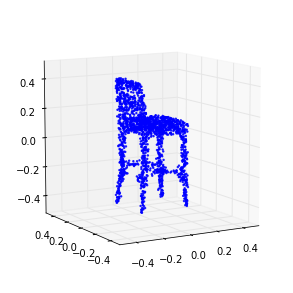

211 (1.3815458288899174, 0.69533642795350814)
212 (1.3826748689015707, 0.70702303118175935)
213 (1.3801780841968678, 0.70991848221531617)
214 (1.3785413203416048, 0.69239161058708476)
215 (1.3794251839319864, 0.72060950376369337)
216 (1.3836368905173408, 0.69625746364946717)
217 (1.3809260924657185, 0.7038721804265623)
218 (1.3789507936548304, 0.71255647694623026)
219 (1.3787651432885064, 0.69125588028519247)
220 (1.3829730916906287, 0.71632036456355341)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-220 is not in all_model_checkpoint_paths. Manually adding it.


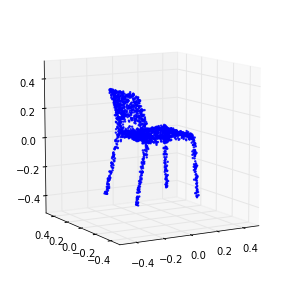

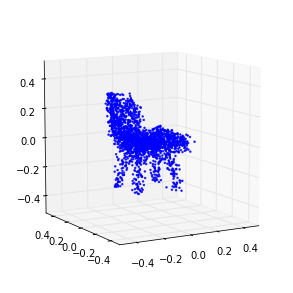

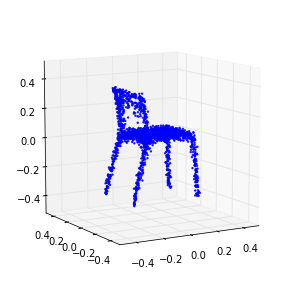

221 (1.3813859851272017, 0.6952085419937416)
222 (1.3800494759171098, 0.70131368460478605)
223 (1.3775494036851106, 0.71970278068825055)
224 (1.3803685497354579, 0.68959374030431109)
225 (1.3839517452098704, 0.7164341538040726)
226 (1.3834119681958799, 0.70230217156586827)
227 (1.3805270998566239, 0.69650290277269156)
228 (1.3786987825676247, 0.72236051382841893)
229 (1.379638742517542, 0.69017455092182867)
230 (1.3816826007984302, 0.72340567818394419)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-230 is not in all_model_checkpoint_paths. Manually adding it.


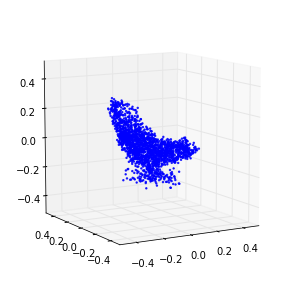

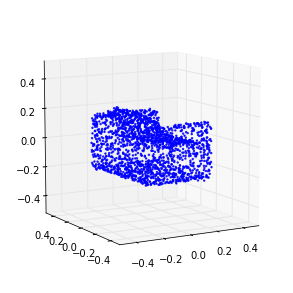

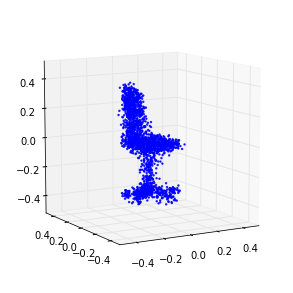

231 (1.382411653024179, 0.68963689848228737)
232 (1.381045698236536, 0.70993493883698078)
233 (1.380465888094019, 0.70081387846558185)
234 (1.378823373052809, 0.69762741459740529)
235 (1.3802487170254742, 0.71416718650747224)
236 (1.380675850974189, 0.68837970318617647)
237 (1.3832252749690304, 0.71161767376793761)
238 (1.3812695220664695, 0.70414323188640449)
239 (1.3793601857291327, 0.69347195846063114)
240 (1.3794685257805719, 0.72089454112229523)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-240 is not in all_model_checkpoint_paths. Manually adding it.


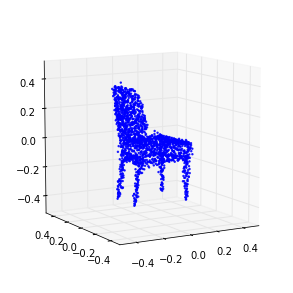

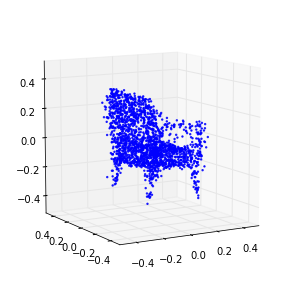

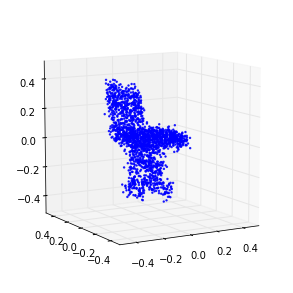

241 (1.3798392913959645, 0.69426813390519881)
242 (1.3823194989451655, 0.71531529029210406)
243 (1.3818309386571248, 0.70210240593662965)
244 (1.3784881061977809, 0.69863491853078208)
245 (1.3794880637416134, 0.72437114494818233)
246 (1.3779743247561984, 0.68678117858039012)
247 (1.3821705517945466, 0.72501904125566841)
248 (1.3809864838918051, 0.69022917791649152)
249 (1.3830852526205557, 0.71549620584205342)
250 (1.3820858381412648, 0.69288065080289485)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-250 is not in all_model_checkpoint_paths. Manually adding it.


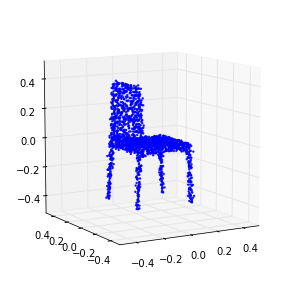

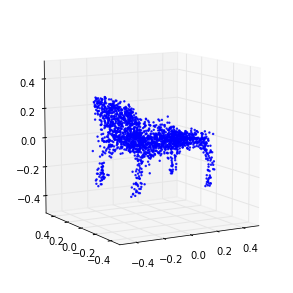

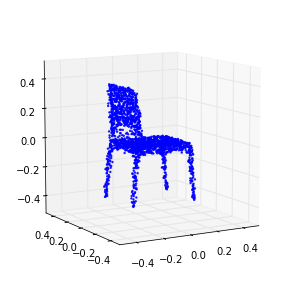

251 (1.3821636588485153, 0.70572889071923717)
252 (1.3789138131671481, 0.71134688942520707)
253 (1.3777210438693011, 0.69101308098545777)
254 (1.3806681677147195, 0.72738757089332295)
255 (1.3811576057363439, 0.68356665637758041)
256 (1.3839484152970492, 0.72220703451721757)
257 (1.3796104793195372, 0.68638682542023832)
258 (1.3816601903350265, 0.71534917045522617)
259 (1.3820836552867184, 0.69608700054663197)
260 (1.3818969196743436, 0.69882094595167377)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-260 is not in all_model_checkpoint_paths. Manually adding it.


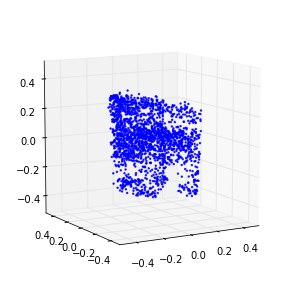

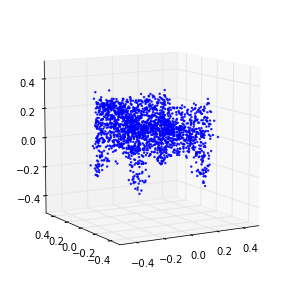

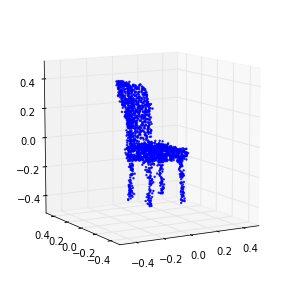

261 (1.3807212917893021, 0.71136691305372446)
262 (1.3782428229296648, 0.69786356952455308)
263 (1.3812461385020502, 0.71727906024014509)
264 (1.3824619628764965, 0.68478713786160506)
265 (1.3810751031946253, 0.71804823257305006)
266 (1.3824142464885005, 0.6927739205183806)
267 (1.3812825679779053, 0.70091153692316122)
268 (1.3809872353518451, 0.70476231310102677)
269 (1.3787733846240573, 0.69283902512656315)
270 (1.381948866667571, 0.71067612259476276)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-270 is not in all_model_checkpoint_paths. Manually adding it.


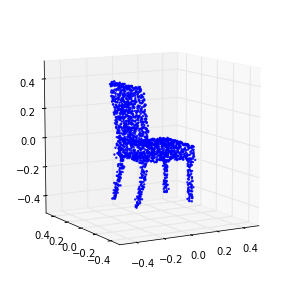

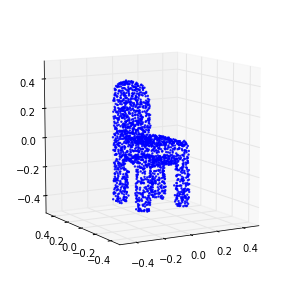

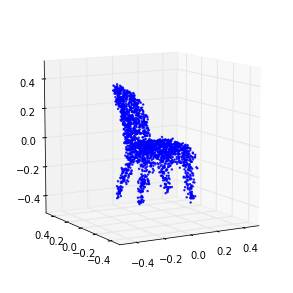

271 (1.3821137225186384, 0.69620578730547866)
272 (1.3803625018508345, 0.69653778650142528)
273 (1.3802023949446502, 0.71293964562592682)
274 (1.3823192243222837, 0.69518277821717434)
275 (1.3797427036144114, 0.70211522402586757)
276 (1.3821389895898324, 0.71419165796703765)
277 (1.381478472992226, 0.70059350375775942)
278 (1.3797385012661969, 0.70145999987920127)
279 (1.380394321900827, 0.70581503665005718)
280 (1.380514227019416, 0.70266123038751105)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-280 is not in all_model_checkpoint_paths. Manually adding it.


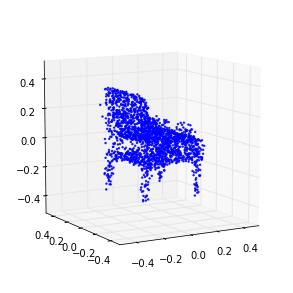

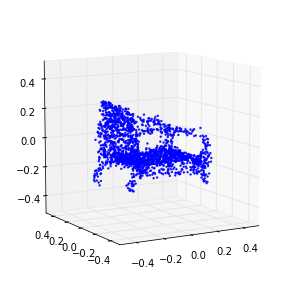

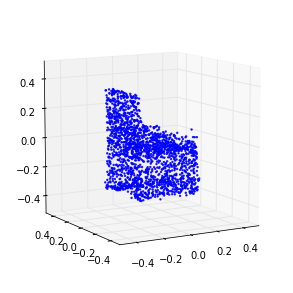

281 (1.3801763075369375, 0.6938673699343646)
282 (1.3826901780234442, 0.70712043929983071)
283 (1.3804655975765652, 0.70292837266568786)
284 (1.3797333196357444, 0.70077301661173508)
285 (1.3786266989178129, 0.71567539815549497)
286 (1.3836113293965657, 0.69459503182658444)
287 (1.3817922848242301, 0.6976737146024351)
288 (1.3808183793668394, 0.71977537208133269)
289 (1.3788160182811595, 0.68696533794756287)
290 (1.3814921105349505, 0.71793852514690826)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-290 is not in all_model_checkpoint_paths. Manually adding it.


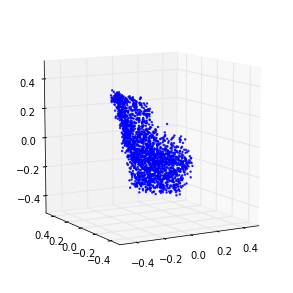

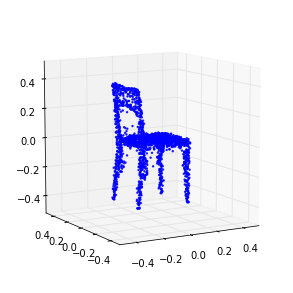

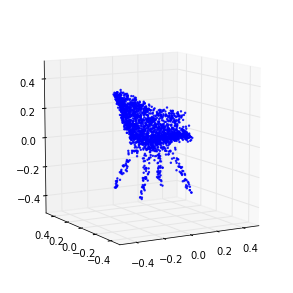

291 (1.3814278841018677, 0.69602082305484347)
292 (1.38032125543665, 0.69863911249019484)
293 (1.3802536028402823, 0.7161464744144016)
294 (1.3776435260419493, 0.68783452157621028)
295 (1.3800821401454784, 0.72705508779596395)
296 (1.3837204853693643, 0.68438387667691269)
297 (1.3834760480456882, 0.71957742461451779)
298 (1.3803562914883649, 0.69179056662100336)
299 (1.3825016798796477, 0.70914849837621052)
300 (1.3799772810052942, 0.70371375834500349)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-300 is not in all_model_checkpoint_paths. Manually adding it.


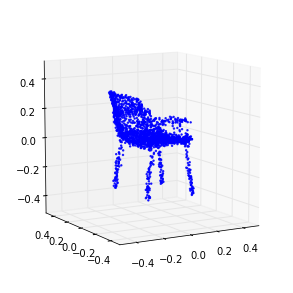

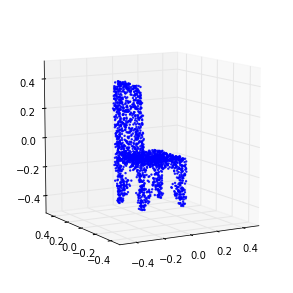

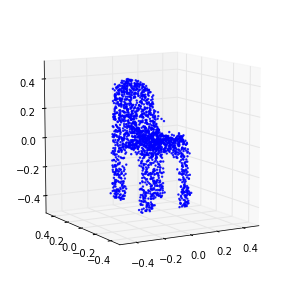

301 (1.3812433410573888, 0.70054640151836256)
302 (1.3797053866916233, 0.70828702935466059)
303 (1.3796763367123075, 0.69148508840137057)
304 (1.3808238506317139, 0.70920955207612779)
305 (1.3807983742819891, 0.6965843456762808)
306 (1.3810811440149944, 0.69946249679282857)
307 (1.3817999442418416, 0.71049459863592079)
308 (1.3778203964233398, 0.69414514833026464)
309 (1.3820488117359302, 0.71402586080409858)
310 (1.3830403513378566, 0.69014434814453129)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-310 is not in all_model_checkpoint_paths. Manually adding it.


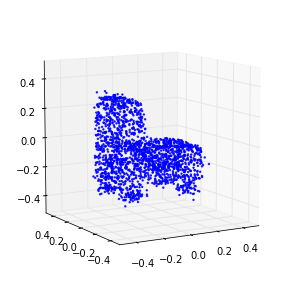

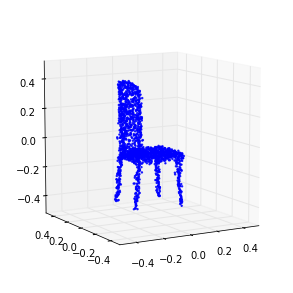

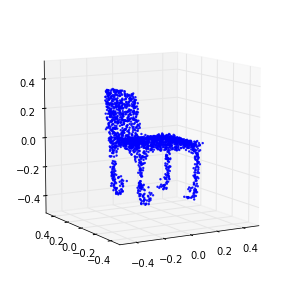

311 (1.3810200682392826, 0.70260119526474563)
312 (1.3805483199931956, 0.70966120516812359)
313 (1.3815742545657688, 0.69189659842738394)
314 (1.3813455272603918, 0.70875012653845326)
315 (1.3833023892508614, 0.70144456448378389)
316 (1.3807865619659423, 0.69581787895273284)
317 (1.3801906541541771, 0.70820770970097291)
318 (1.3806258775569775, 0.68989743435824358)
319 (1.3814475465703893, 0.71323352036652743)
320 (1.3825044949849448, 0.6921799421310425)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-320 is not in all_model_checkpoint_paths. Manually adding it.


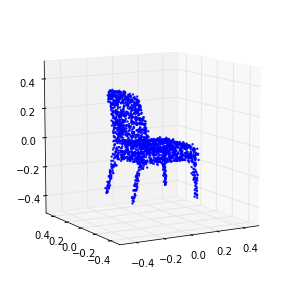

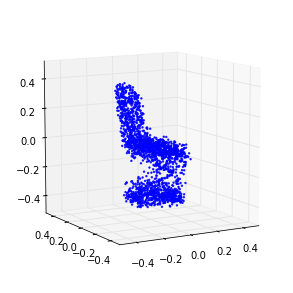

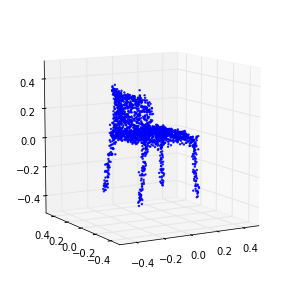

321 (1.3812813140727855, 0.70000757288049764)
322 (1.3790912946065268, 0.72305762767791748)
323 (1.3806961589389377, 0.68226424455642698)
324 (1.384090613435816, 0.71888193024529357)
325 (1.3809855575914736, 0.69058054685592651)
326 (1.3824864405172843, 0.71704974527712217)
327 (1.3799730477509675, 0.69866421399293122)
328 (1.3814155410837243, 0.70769352029871058)
329 (1.381590603016041, 0.69751426025673191)
330 (1.381334408124288, 0.70297480424245196)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-330 is not in all_model_checkpoint_paths. Manually adding it.


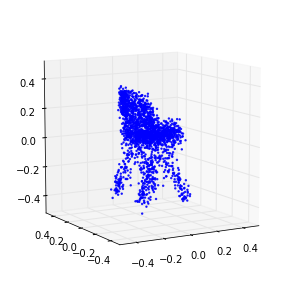

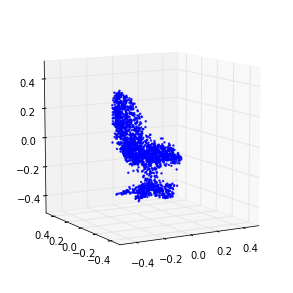

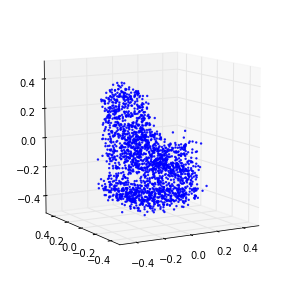

331 (1.3815502882003785, 0.70813484412652472)
332 (1.3796944997928762, 0.68905793737482146)
333 (1.3800369448131986, 0.71597905291451347)
334 (1.3809783520521941, 0.68877589216938728)
335 (1.381741503432945, 0.71115619473987157)
336 (1.3815060712673046, 0.69289729904245445)
337 (1.381371514002482, 0.70689923012698141)
338 (1.3815708619576914, 0.70335134841777658)
339 (1.3824506371109575, 0.69438307197005655)
340 (1.3807770852689389, 0.70743640043117384)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-340 is not in all_model_checkpoint_paths. Manually adding it.


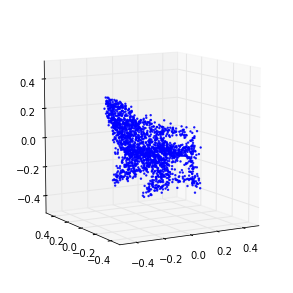

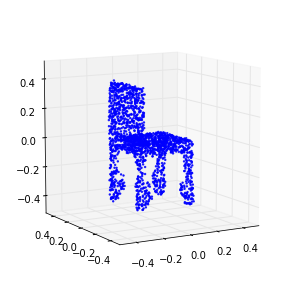

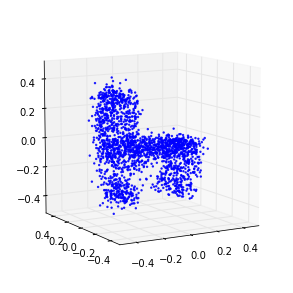

341 (1.3809950122126826, 0.69164037395406652)
342 (1.3817705834353411, 0.70449715543676306)
343 (1.3825116528405084, 0.70115914300636006)
344 (1.3811185978077076, 0.69317925682774295)
345 (1.381737235740379, 0.70946041301444729)
346 (1.3813983669987431, 0.70006669053324944)
347 (1.3819345906928733, 0.70525812043084035)
348 (1.3806186843801427, 0.70712574896989044)
349 (1.3814738194147747, 0.6919508439523202)
350 (1.3807676836296363, 0.7083773595315439)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-350 is not in all_model_checkpoint_paths. Manually adding it.


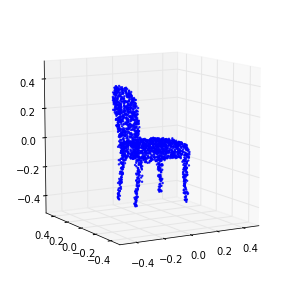

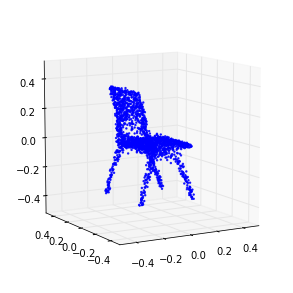

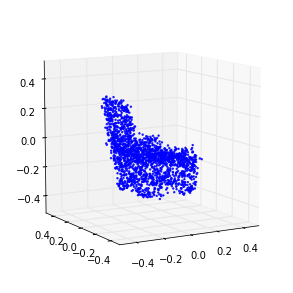

351 (1.3814267308623702, 0.69405432895377828)
352 (1.3806183823832758, 0.70296357958405109)
353 (1.3800827662150066, 0.7157755057017009)
354 (1.3812990462338484, 0.68641902252479836)
355 (1.3814215554131402, 0.71530678978672735)
356 (1.3803351349300808, 0.69572563171386714)
357 (1.3814739094840156, 0.69719452284000538)
358 (1.3800439322436298, 0.71515183404639915)
359 (1.3802493404459071, 0.68659828415623414)
360 (1.3813495123827899, 0.72705232125741459)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-360 is not in all_model_checkpoint_paths. Manually adding it.


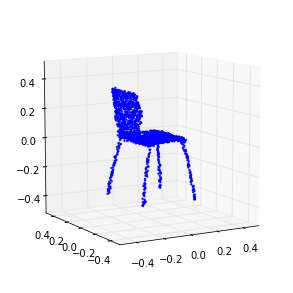

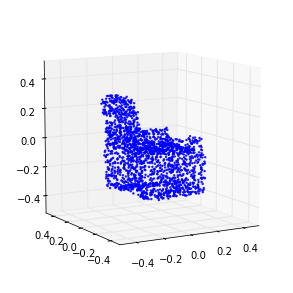

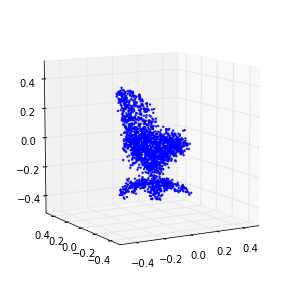

361 (1.3828389803568522, 0.68349978835494429)
362 (1.3802206154222842, 0.71937932791533299)
363 (1.3807967433223018, 0.6846098599610505)
364 (1.3827930194360238, 0.71493113526591545)
365 (1.382026242326807, 0.69281081623501251)
366 (1.3802256010196827, 0.71162224654798156)
367 (1.3815556517353764, 0.68697774189489857)
368 (1.3823152330186632, 0.71066647458959509)
369 (1.3812112711094044, 0.6957584946243851)
370 (1.3814667613418015, 0.69960743321312802)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-370 is not in all_model_checkpoint_paths. Manually adding it.


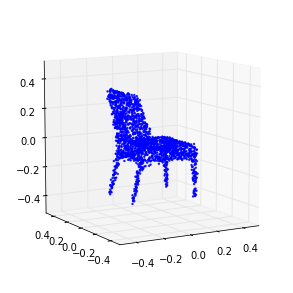

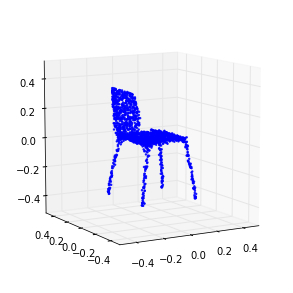

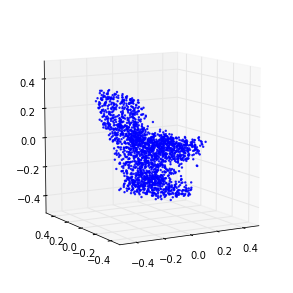

371 (1.3804295010036893, 0.71172552373674181)
372 (1.3798684641166969, 0.68643162956944215)
373 (1.3795990202162001, 0.71791358523898652)
374 (1.3818702194425794, 0.68688313077997276)
375 (1.3814331875907051, 0.71661381279980696)
376 (1.3809932346697207, 0.6929473364794696)
377 (1.381131120081301, 0.70151821860560659)
378 (1.3803254551357693, 0.71160929114730265)
379 (1.382815287731312, 0.69694637678287652)
380 (1.3799279990019622, 0.71667824939445213)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-380 is not in all_model_checkpoint_paths. Manually adding it.


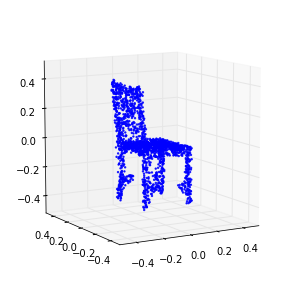

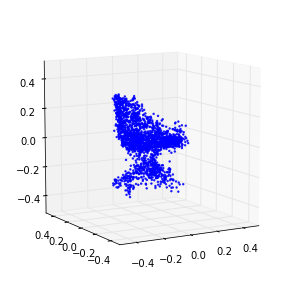

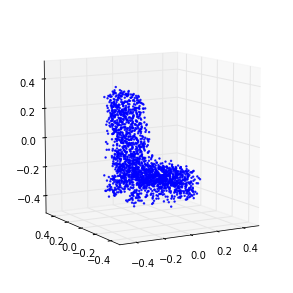

381 (1.3799282003332067, 0.69050568298057269)
382 (1.3810385103578922, 0.71493479896474765)
383 (1.3814270558180632, 0.68172842573236536)
384 (1.3830552436687329, 0.71724333718970967)
385 (1.380171004931132, 0.68833586904737687)
386 (1.3819199985928006, 0.71075868606567383)
387 (1.3811929746910379, 0.69149236414167614)
388 (1.3818718574665212, 0.70659496210239547)
389 (1.3810813250365082, 0.70110565821329751)
390 (1.3812902300446122, 0.69785128743560221)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-390 is not in all_model_checkpoint_paths. Manually adding it.


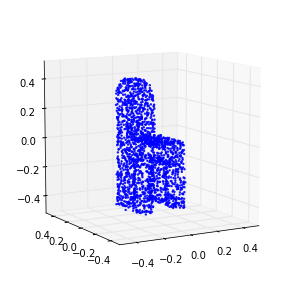

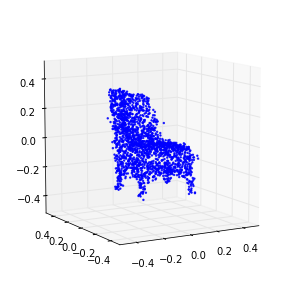

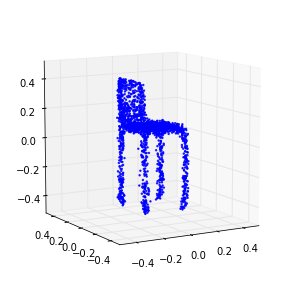

391 (1.3821045831397727, 0.70293989711337623)
392 (1.379396947224935, 0.69495876939208423)
393 (1.3816165738635593, 0.70450761583116317)
394 (1.3810405863655939, 0.69753148732361969)
395 (1.3809870569794267, 0.70496616893344455)
396 (1.3806162842997798, 0.70616143544514975)
397 (1.3766609810016774, 0.70188273765422682)
398 (1.3831828223334419, 0.72014027436574302)
399 (1.3794763662196972, 0.68869626522064209)
400 (1.3817891906808923, 0.73758625895888719)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-400 is not in all_model_checkpoint_paths. Manually adding it.


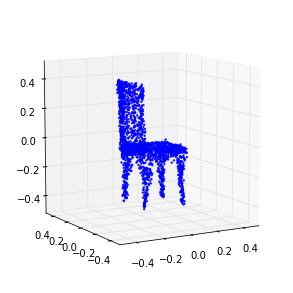

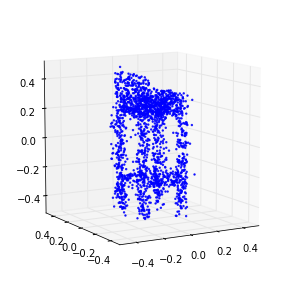

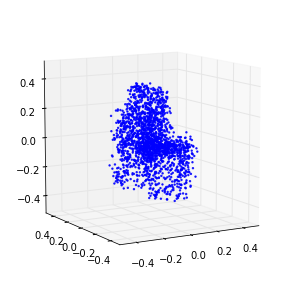

401 (1.383195193608602, 0.67161888369807488)
402 (1.383813660233109, 0.73196833133697514)
403 (1.3794524175149423, 0.68120526296121098)
404 (1.381525625122918, 0.716179288316656)
405 (1.3823861219264844, 0.68669086385656286)
406 (1.381324205575166, 0.71170164346694942)
407 (1.3805094365720396, 0.68520524457648946)
408 (1.3816857938413267, 0.70845554228182195)
409 (1.3807101240864506, 0.69193984579156942)
410 (1.3799901211703265, 0.70659013633374812)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-410 is not in all_model_checkpoint_paths. Manually adding it.


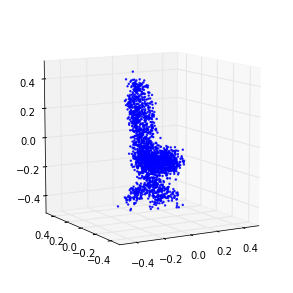

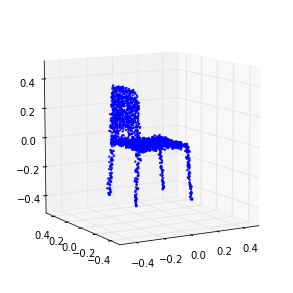

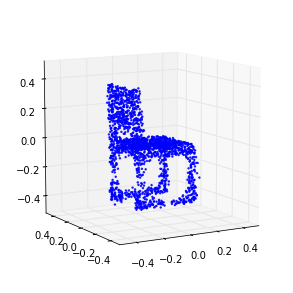

411 (1.3808040283344409, 0.70673266825852565)
412 (1.3808574676513672, 0.69145509446108788)
413 (1.3805213592670582, 0.70628065709714538)
414 (1.380786449820907, 0.69751143190595843)
415 (1.3828152894973755, 0.70923250648710467)
416 (1.3789102474848429, 0.69931099282370668)
417 (1.3813752677705553, 0.70213841376481234)
418 (1.3827974655010082, 0.70558488942958686)
419 (1.380179233904238, 0.69025559292899241)
420 (1.3798730700104325, 0.71328892531218357)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-420 is not in all_model_checkpoint_paths. Manually adding it.


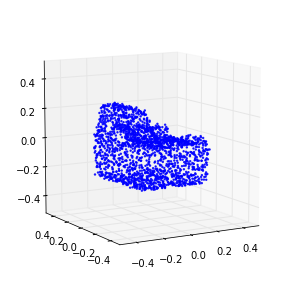

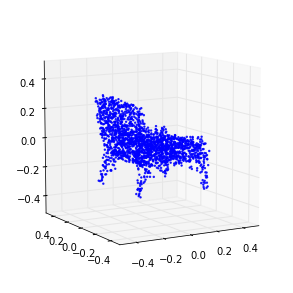

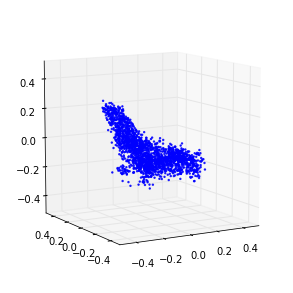

421 (1.3811654452924376, 0.6905867726714523)
422 (1.3816913172050758, 0.70921867820951678)
423 (1.3817600559305261, 0.69421837859683566)
424 (1.381230154743901, 0.70092197524176703)
425 (1.3813503812860559, 0.70293831207134105)
426 (1.378760482646801, 0.69045994590829918)
427 (1.3832050606056496, 0.71349452160022875)
428 (1.3809509771841544, 0.69096078166255248)
429 (1.3809627082612779, 0.70206014800954752)
430 (1.3809326551578662, 0.70080593117961176)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-430 is not in all_model_checkpoint_paths. Manually adding it.


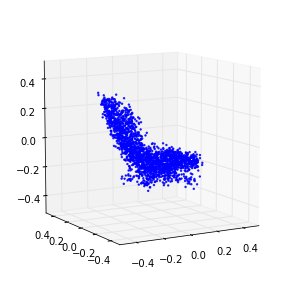

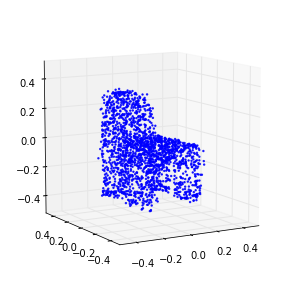

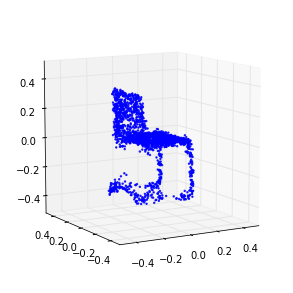

431 (1.3799517163523922, 0.69256654580434163)
432 (1.3807855853327999, 0.71850394407908125)
433 (1.381222035266735, 0.69510123641402632)
434 (1.3828619232884161, 0.69998233627389983)
435 (1.3800658720510977, 0.70996183201118757)
436 (1.3805884264133594, 0.68928041060765588)
437 (1.3829308342050624, 0.70404302764821936)
438 (1.3807138946321276, 0.70288813820591678)
439 (1.3801212513888323, 0.69163055773134585)
440 (1.3797919706062034, 0.71575782034132218)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-440 is not in all_model_checkpoint_paths. Manually adding it.


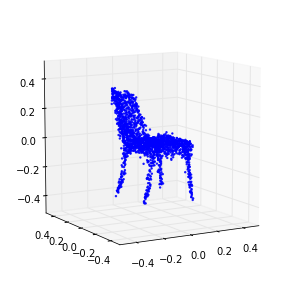

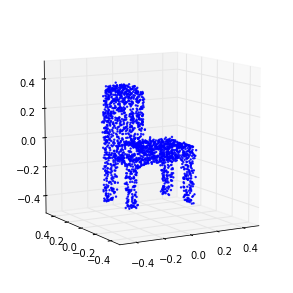

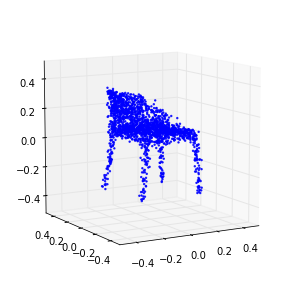

441 (1.3812088727951051, 0.68393666126109931)
442 (1.3810240242216323, 0.70745794022524799)
443 (1.3812622317561396, 0.70105000734329226)
444 (1.3814115709728665, 0.69759452342987061)
445 (1.3811864517353198, 0.70969484249750769)
446 (1.3801652740549157, 0.69401512764118334)
447 (1.3820425943092063, 0.70053308319162444)
448 (1.3799821571067528, 0.70677812805882212)
449 (1.3807728749734385, 0.69723555688504824)
450 (1.3800267740532204, 0.6971697533572162)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-450 is not in all_model_checkpoint_paths. Manually adding it.


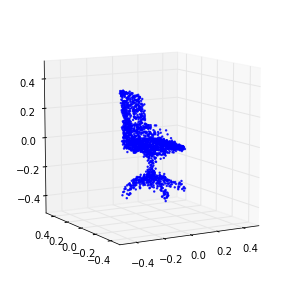

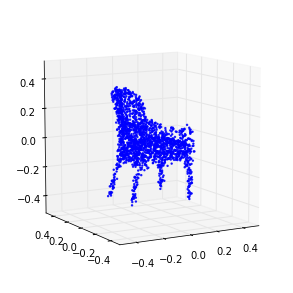

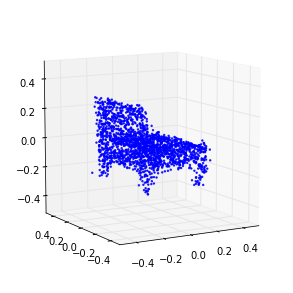

451 (1.3813599895547937, 0.70723065667682228)
452 (1.3809187588868317, 0.69515085396943266)
453 (1.3807387678711502, 0.70112787220213146)
454 (1.38003387009656, 0.70216540937070493)
455 (1.3794647914391978, 0.69975969173290109)
456 (1.3809018938629716, 0.69777447382609048)
457 (1.3813150688453957, 0.70301675178386547)
458 (1.3790725955256709, 0.7053652820763765)
459 (1.3818417054635508, 0.6975688876929107)
460 (1.3831245537157413, 0.71629002977300571)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-460 is not in all_model_checkpoint_paths. Manually adding it.


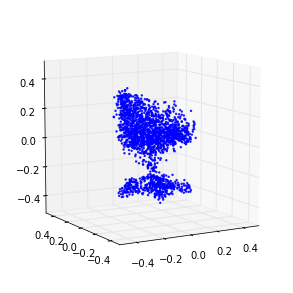

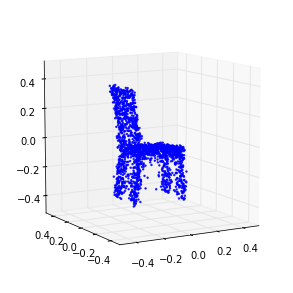

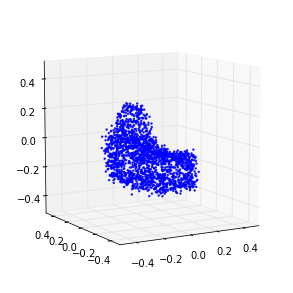

461 (1.3823171147593745, 0.69568975987257786)
462 (1.3807403449658995, 0.7015043170363815)
463 (1.3800123099927548, 0.70607281658384535)
464 (1.3803185109738951, 0.6950653230702436)
465 (1.3799262647275572, 0.70938007257602831)
466 (1.3789707192668208, 0.6949163653232433)
467 (1.3790801551606919, 0.70997096255973535)
468 (1.3820112873006749, 0.68704616891013248)
469 (1.3835794342888725, 0.71600575623688878)
470 (1.3807332197825113, 0.69217215732291892)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-470 is not in all_model_checkpoint_paths. Manually adding it.


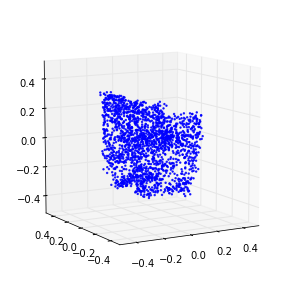

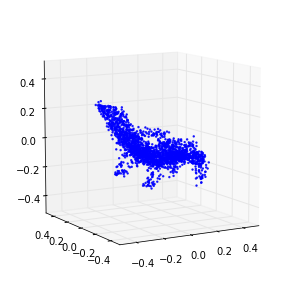

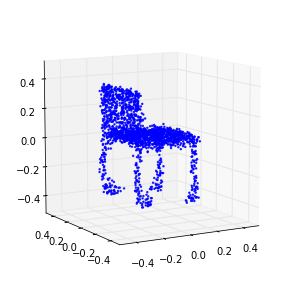

471 (1.3819252208427146, 0.70135947686654554)
472 (1.3805850841380931, 0.69780052238040502)
473 (1.3811361754382099, 0.69732023168493196)
474 (1.3804843602357086, 0.70940249054520221)
475 (1.3812300699728506, 0.69131986962424385)
476 (1.3800787060349076, 0.69992737858383747)
477 (1.381518139662566, 0.70448901167622324)
478 (1.3810408097726328, 0.69481500343040181)
479 (1.3794235229492187, 0.69968461372234203)
480 (1.3814498247923674, 0.7047219660547045)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-480 is not in all_model_checkpoint_paths. Manually adding it.


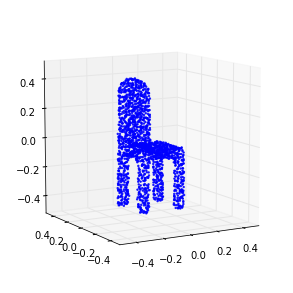

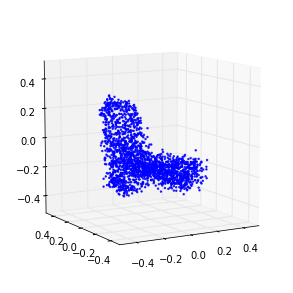

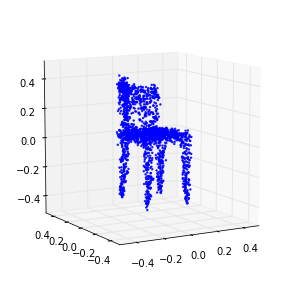

481 (1.3797193430088184, 0.69528606909292712)
482 (1.3819275776545206, 0.70078118642171228)
483 (1.3780924037650779, 0.715864301610876)
484 (1.3782946922160961, 0.69310590602733468)
485 (1.3833575292869851, 0.71245758710084139)
486 (1.3817543886325978, 0.68831801105428625)
487 (1.3806268983417087, 0.71781320042080354)
488 (1.3803085177033037, 0.69029310058664395)
489 (1.3807389815648397, 0.71637310760992545)
490 (1.3804863567705508, 0.68795493973626032)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-490 is not in all_model_checkpoint_paths. Manually adding it.


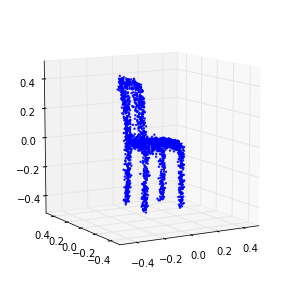

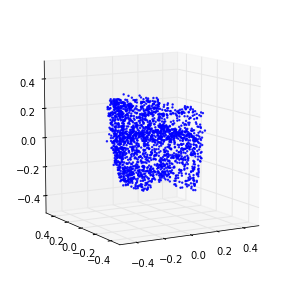

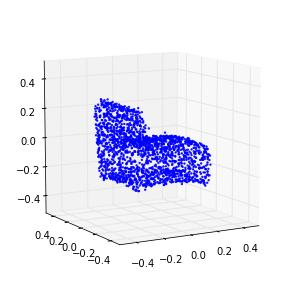

491 (1.3803301016489664, 0.70740191804038155)
492 (1.380024203547725, 0.7031670702828301)
493 (1.3798645681805082, 0.70148329116680008)
494 (1.379415135913425, 0.70915859275394011)
495 (1.3807655608212506, 0.69435109341586077)
496 (1.3810428822482075, 0.70514015533305985)
497 (1.37890646899188, 0.69688912541778003)
498 (1.3818878217979713, 0.70920040651603977)
499 (1.379555137069137, 0.69780907763375177)
500 (1.3816238844836199, 0.70147182676527231)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_gan_ae_18_emd_chair_2048_best_epoch/models.ckpt-500 is not in all_model_checkpoint_paths. Manually adding it.


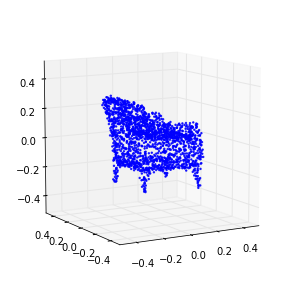

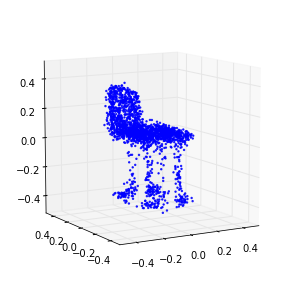

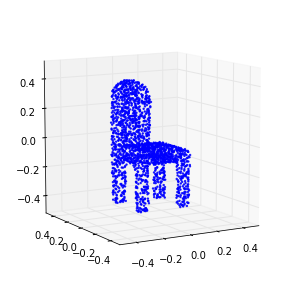

In [10]:
save_dir = osp.join(synthetic_data_out_dir, experiment_name)
save_dir = create_dir(save_dir)

buf_size = 1 # flush each line
if do_training:    
    train_stats = []
    log_file = open(osp.join(train_dir, 'train_stats.txt'), 'a', buf_size)
    for _ in range(max_epochs):        
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss                
        log_file.write('%04d\t%.9f\t%.9f\t%.4f\n' % (epoch, loss[0], loss[1], duration / 60.0))        

        if save_model and (epoch % saver_step == 0 or epoch <= 5):
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            syn_latent_data = gan.generate(n_syn_samples, noise_params)
            syn_data = ae.decode(syn_latent_data)
            np.savez(osp.join(save_dir, 'epoch_' + str(epoch)), syn_data)
            for k in range(3):
                Point_Cloud(syn_data[k]).plot(in_u_sphere=True)
                        
        train_stats.append((epoch,) + loss)
    log_file.close()

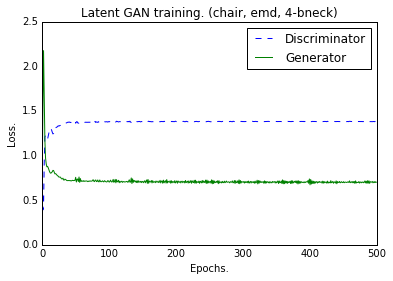

In [11]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s, %s-bneck)' %(class_name, ae_loss, ae.bottleneck_size))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')
    
    plt.savefig(osp.join(train_dir, 'training_curve.png'))